# pyWATTS Übung 2023

## Agenda 

Data Analysis

    - Description of the Dataset
    - Data Visualisation
    - Overview Weekday vs Weekend ?
    - Seasonal Decomposition

Forecasting with PyWatts

    - Normalisation ?
    - Calendat Featrues?
    - 




## Chat GPT - What is Pywatts?
### Chat GPT's Opinion

>“Pywatts is an open-source Python library designed to simplify time series analysis. It provides users with a range of powerful tools for exploring, visualizing, and modeling time series data. Pywatts is particularly useful for tasks such as forecasting, anomaly detection, and data preprocessing. The library includes a wide range of functionality, including a suite of built-in data loaders for importing time series data from a variety of sources, such as CSV files, databases, and web APIs. Pywatts also includes a range of data preprocessing tools, such as resampling, interpolation, and feature engineering, that can help users to prepare their time series data for analysis. One of the key features of Pywatts is its support for a range of machine learning models for time series analysis. These models include popular algorithms such as ARIMA, LSTM, and GRU models, as well as models for anomaly detection, such as isolation forests and one-class SVMs. Pywatts also provides tools for model training, evaluation, and deployment, making it an ideal platform for both research and production environments. Pywatts is designed to be easy to use, with a simple and intuitive interface that makes it accessible to users with a wide range of backgrounds and skill levels. The library is actively maintained and supported by a community of developers, ensuring that it is up-to-date and compatible with the latest versions of Python and other libraries. Overall, Pywatts is a powerful and flexible tool for anyone working with time series data. Whether you are a researcher, analyst, or data scientist, Pywatts can help you to quickly and easily preprocess, analyze, and model your time series data, enabling you to gain valuable insights and make informed decisions.“

### What is right what is wrong ? 




## Data Loading

In [1]:
import pandas as pd
import statsmodels.api as sm
import pylab
import pywatts
pylab.rcParams['figure.figsize'] = (14, 9)

In [2]:
date_parser = lambda date: pd.Timestamp(pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S'))
data = pd.read_csv("data/data_building_250_ausgrid.csv", index_col="time", parse_dates = ["time"], date_parser=date_parser)
data.head()

,demand,solar
time,,
2010-07-01 00:00:00,2.8490,0.0
2010-07-01 01:00:00,1.4145,0.0
2010-07-01 02:00:00,0.6710,0.0
2010-07-01 03:00:00,0.9220,0.0
2010-07-01 04:00:00,0.3065,0.0


## Data Analysis

In [3]:
data.describe()

,demand,solar
count,26305.000000,26305.000000
mean,0.388521,0.100310
std,0.326975,0.159528
min,0.000000,0.000000
25%,0.149500,0.000000
50%,0.273500,0.000000
75%,0.567000,0.159500
max,4.441000,0.603000


### Compare Workingdays and Weekends

#### Workingdays

<Axes: xlabel='hourofday'>

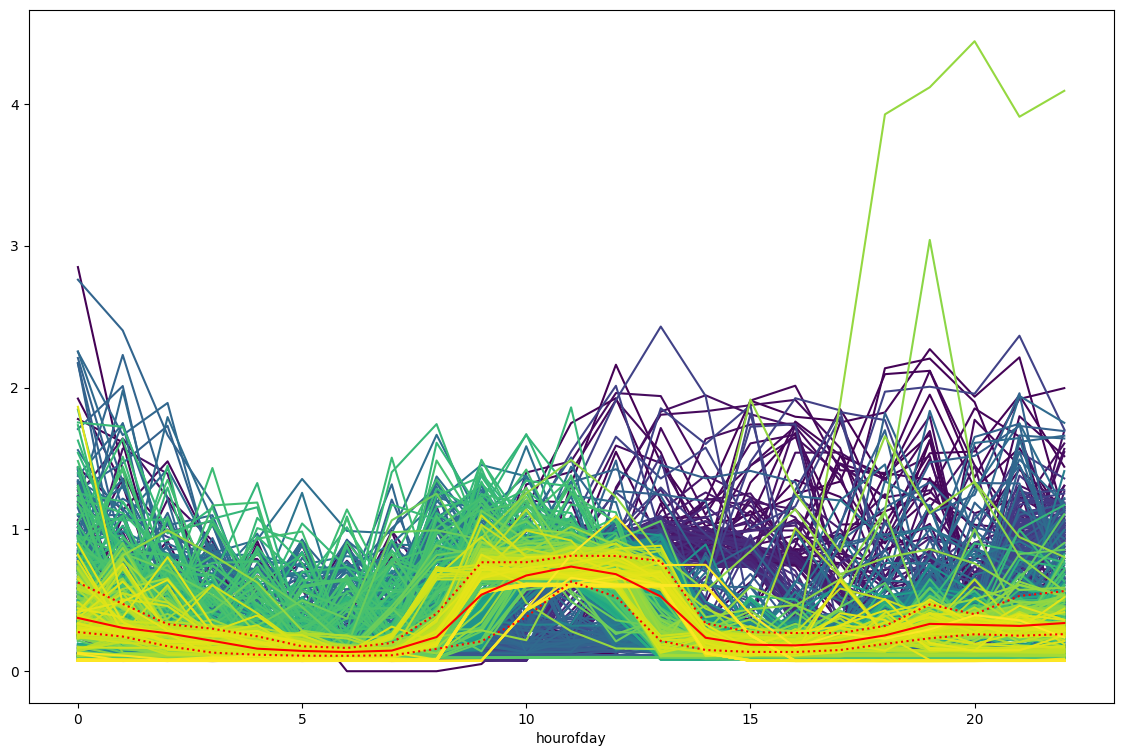

In [4]:
#plots the first two weeks
data["hourofday"] = data.index.hour
data["days_since_start"] = [int(x/(24)) for x in range(0,len(data))]
data['weekday'] = data.index.weekday

pivot = pd.pivot_table(data[data["weekday"] < 5], index=['hourofday'],columns=['days_since_start'], values=['demand'])[:-1]
pivot["demand"].plot(legend=False,colormap="viridis")
pivot.median(axis=1).plot(color="red")
pivot.quantile(0.25,axis=1).plot(color="red",linestyle='dotted')
pivot.quantile(0.75,axis=1).plot(color="red",linestyle='dotted')


#### Weekend

<Axes: xlabel='hourofday'>

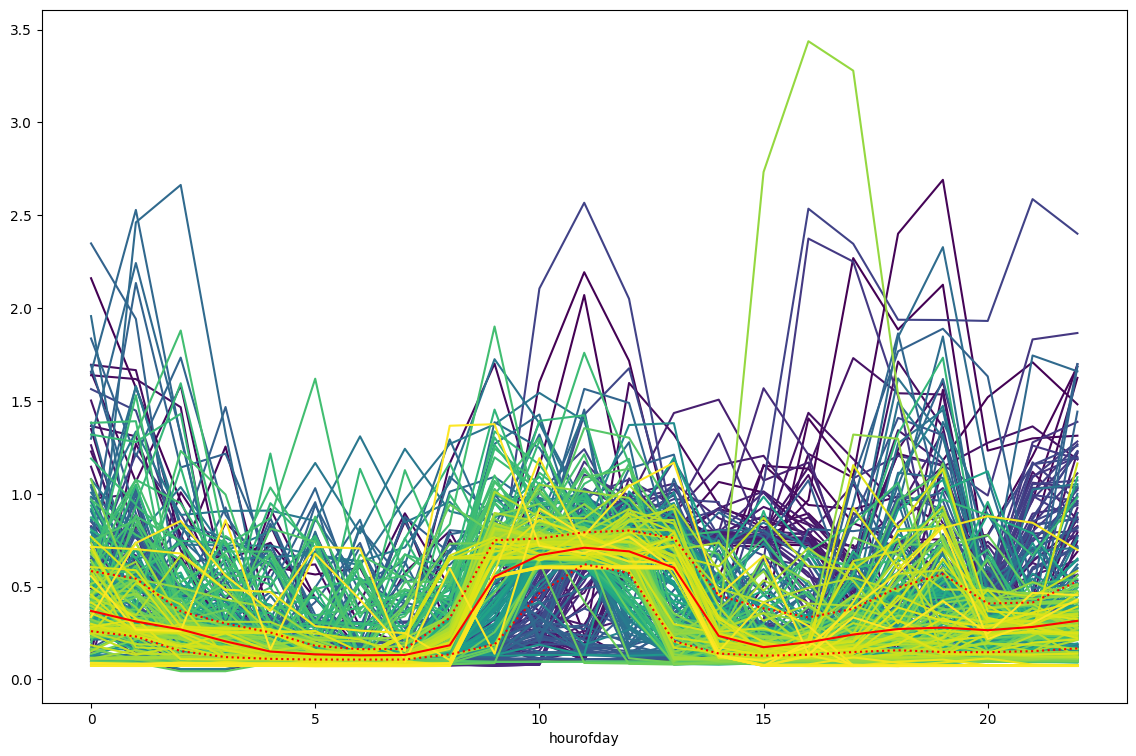

In [5]:

pivot = pd.pivot_table(data[data["weekday"] >= 5], index=['hourofday'],columns=['days_since_start'], values=['demand'])[:-1]
pivot["demand"].plot(legend=False,colormap="viridis")
pivot.median(axis=1).plot(color="red")
pivot.quantile(0.25,axis=1).plot(color="red",linestyle='dotted')
pivot.quantile(0.75,axis=1).plot(color="red",linestyle='dotted')

### Seasonal Decomposition

Can be found here: 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

The additive model is $Y[t] = T[t] + S[t] + e[t]$

The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

#### Visualisation Demand

##### Key Obervations :

- Weekly Pattern visible through the seasonal component Plot 168
- Daily Pattern visble through the seasonal component Plot 24


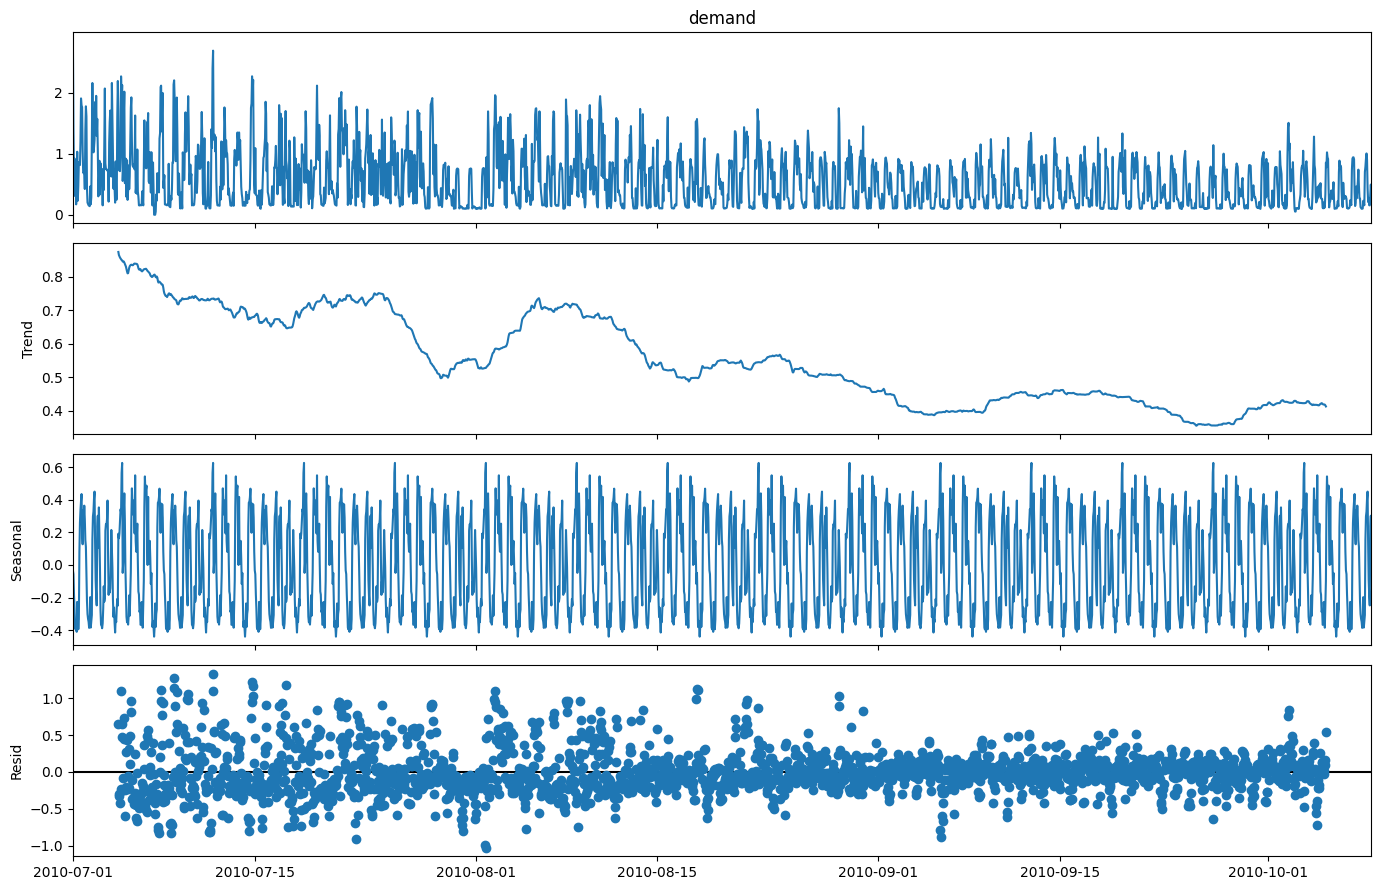

In [6]:
res = sm.tsa.seasonal_decompose(data["demand"][:2400], period= 168)
resplot = res.plot()

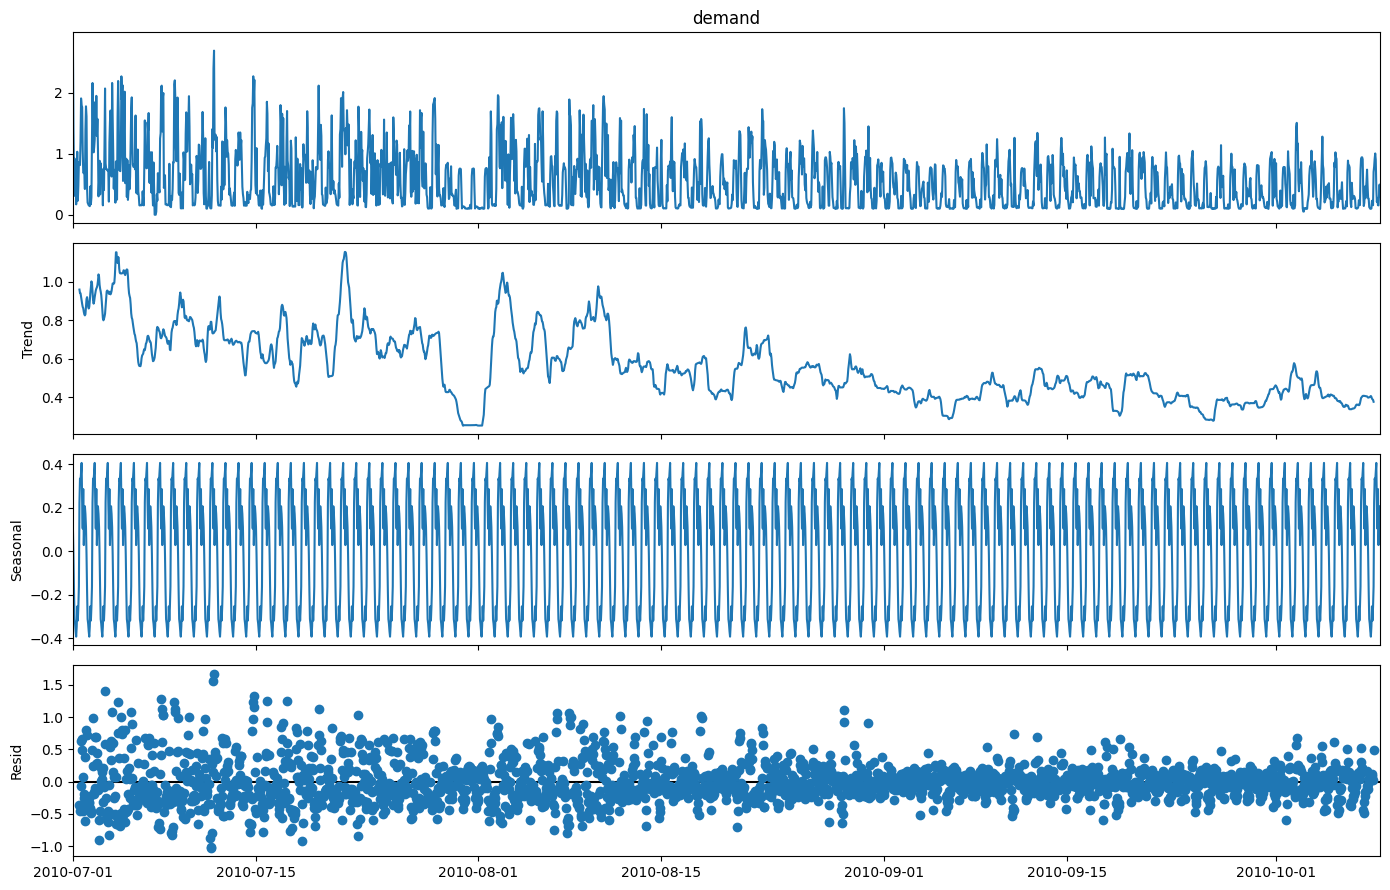

In [7]:
res = sm.tsa.seasonal_decompose(data["demand"][:2400], period=24)
resplot = res.plot()

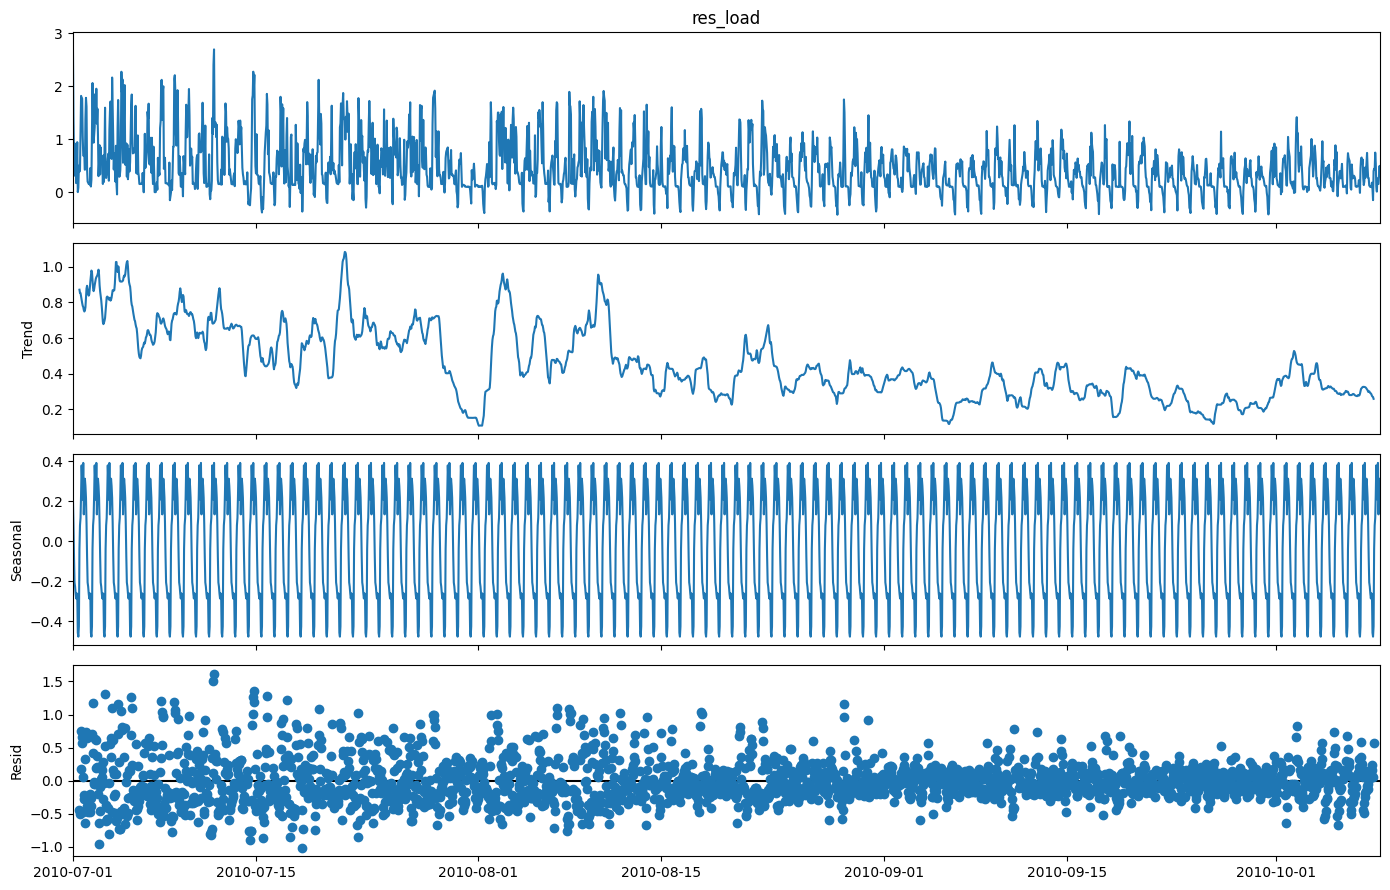

In [8]:
# residual load
data["res_load"] = data["demand"] - data["solar"]
res = sm.tsa.seasonal_decompose(data["res_load"][:2400], period=24)
resplot = res.plot()


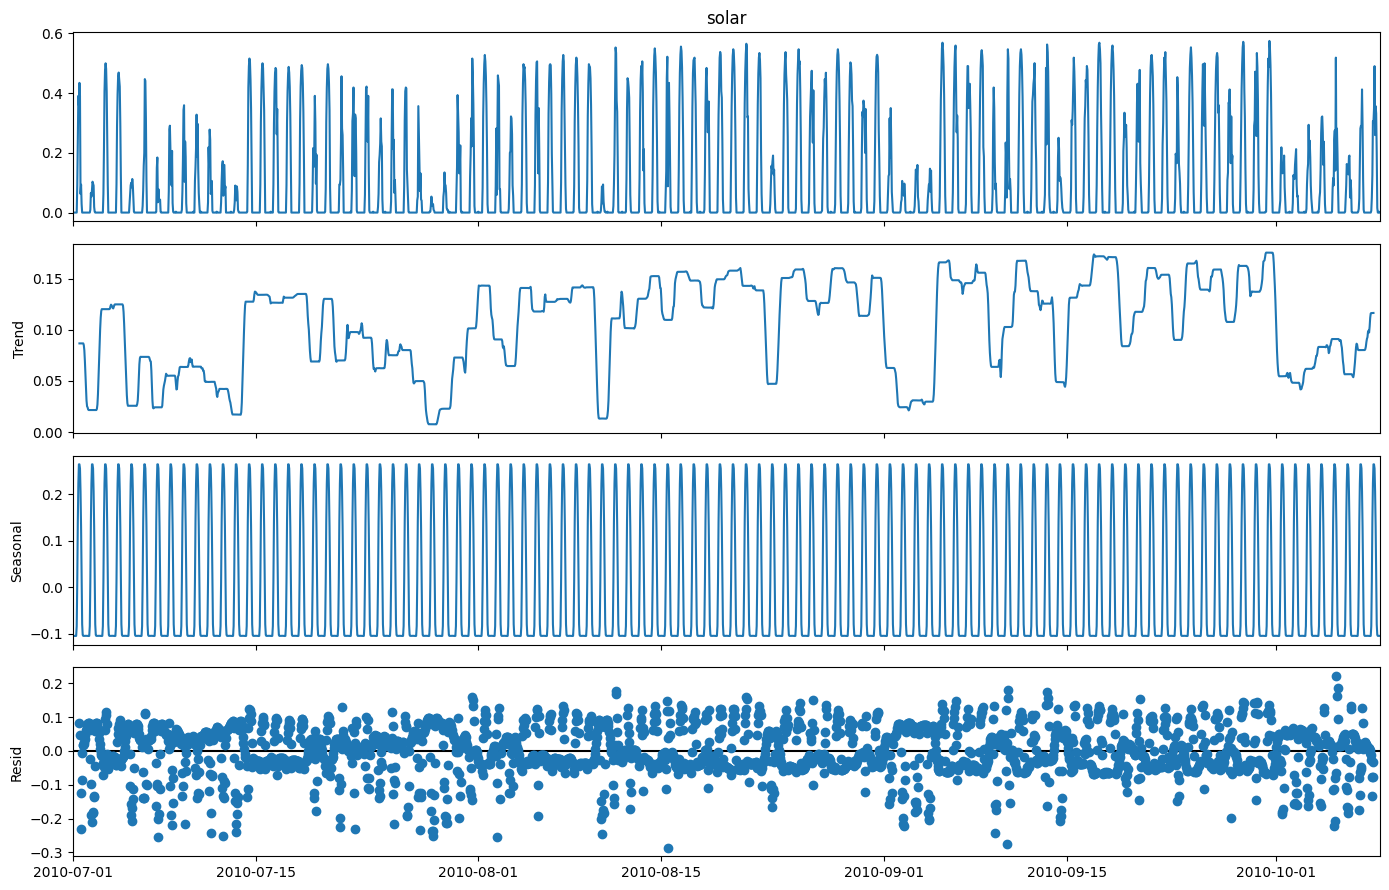

In [9]:
res = sm.tsa.seasonal_decompose(data["solar"][:2400], period=24)
resplot = res.plot()

## Forecasting with pyWatts




RMSE = $\sqrt{\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2}$

In [10]:
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts.modules import SKLearnWrapper
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from pywatts.modules.preprocessing.select import Select
from pywatts.modules.feature_extraction.calendar_extraction import CalendarExtraction, CalendarFeature
from pywatts_pipeline.core.util.computation_mode import ComputationMode
from pywatts.summaries import RMSE, MAE

def get_forecasting_pipeline(forecast_horizon, historical_features,scope_var,sklearn_wrappers):


    forecast_pipeline = Pipeline(f"results/")


    calendar = CalendarExtraction('calendar',continent="oceania",country='NewSouthWales',
                                           features=[CalendarFeature.month_sine, CalendarFeature.month_cos,
                                                     CalendarFeature.weekday_sine, CalendarFeature.weekday_cos,
                                                     CalendarFeature.workday, CalendarFeature.holiday])(x=forecast_pipeline[scope_var])

    data_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler")
    data_scaled = data_scaler(x=forecast_pipeline[scope_var])

    input = Select(start=-historical_features, stop=0, step=1, name="Sample_historical_features")(x=data_scaled)
    target_scaled = Select(start=0, stop=forecast_horizon, step=1, name="Sample_targets")(x=data_scaled)
    

    result_dict= {}
    result_dict_unscaled = {}
    target = data_scaler(x=target_scaled, computation_mode=ComputationMode.Transform,method="inverse_transform")
    
    for forecaster in sklearn_wrappers:
        result_dict[forecaster.name] = forecaster(
        features=input,
        calendar=calendar,
        target=target_scaled,
        )

        result_dict_unscaled[forecaster.name] = data_scaler(x=result_dict[forecaster.name], computation_mode=ComputationMode.Transform,method="inverse_transform")
        

        rmse = RMSE(name="rmse_" + forecaster.name)(y_hat=result_dict_unscaled[forecaster.name] , y=target)
        mae = MAE(name="mae" + forecaster.name)(y_hat=result_dict_unscaled[forecaster.name] , y=target)

    




    return forecast_pipeline, result_dict_unscaled , target



/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name scaler is renamed to scaler_1 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name scaler is renamed to scaler_2 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name scaler is renamed to scaler_3 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-

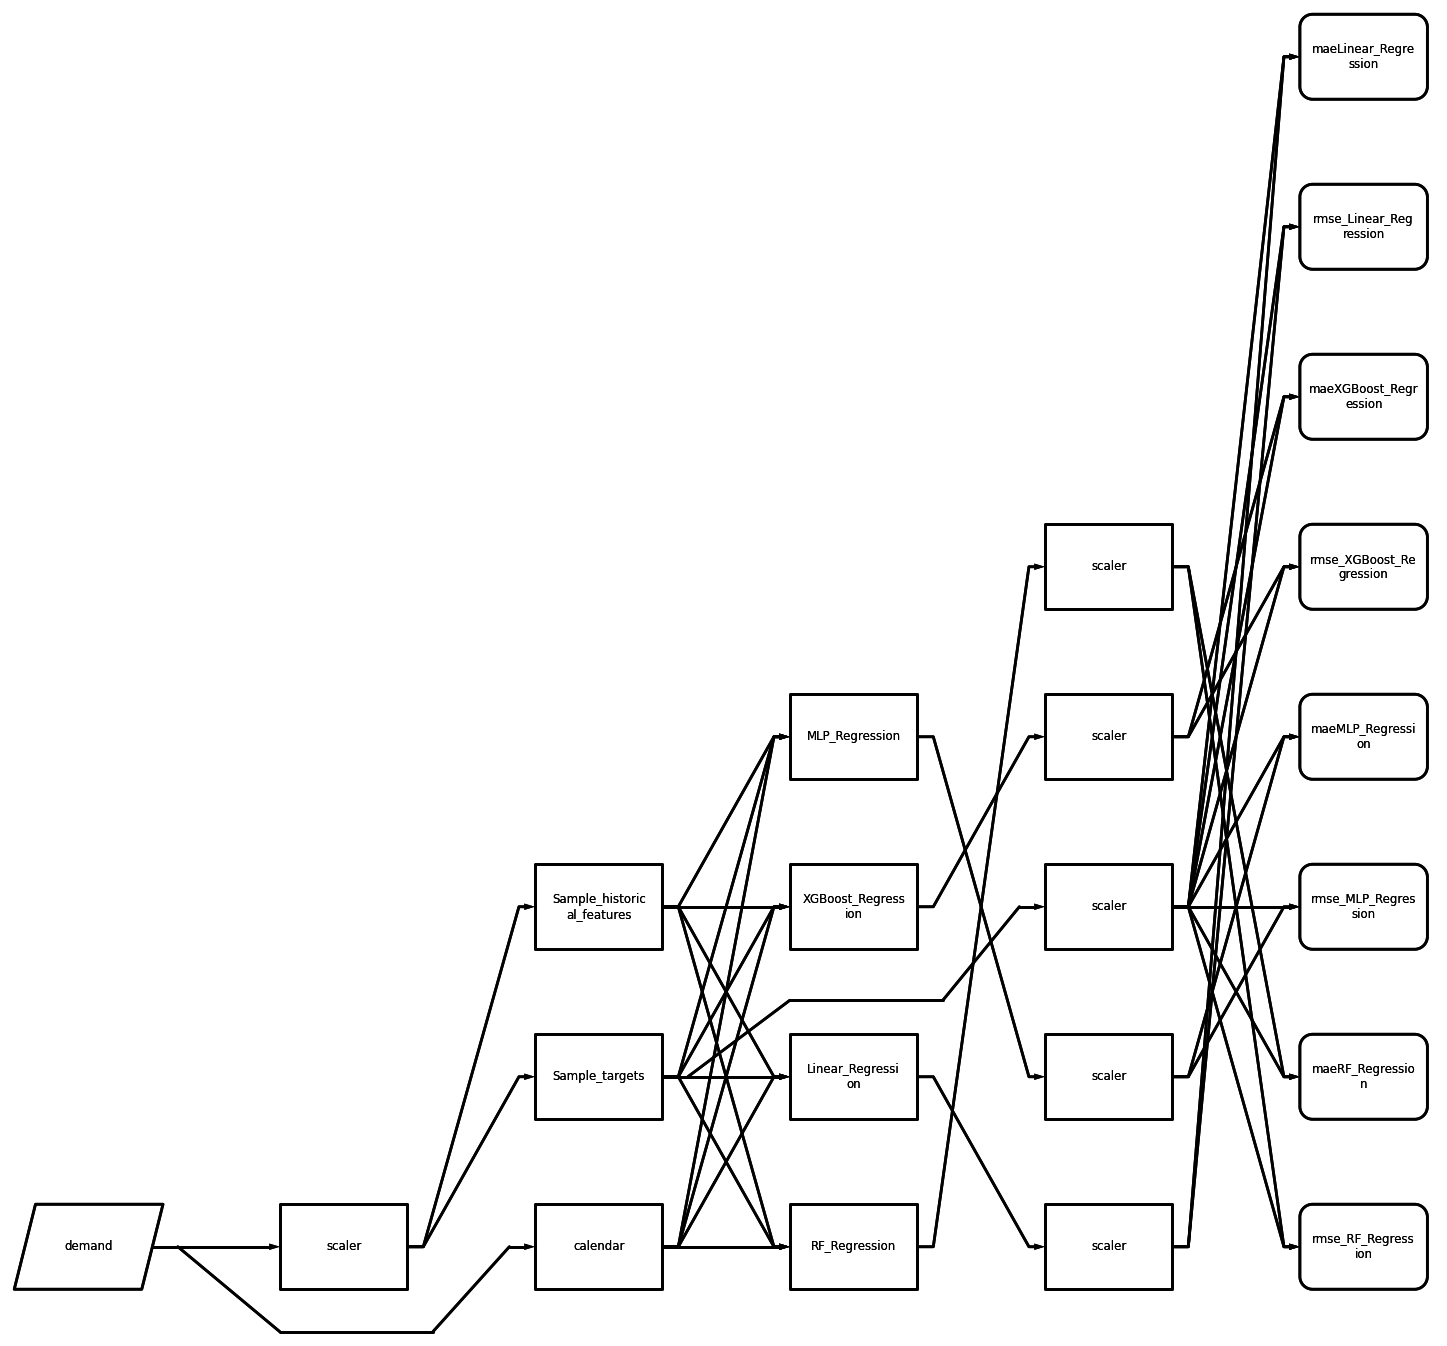

In [11]:
SCOPE_VARIABLE =  ["demand"]
TRAINING_END = pd.Timestamp("2012-06-01")


forecasters = [ SKLearnWrapper(module=RandomForestRegressor(), name="RF_Regression"),
                SKLearnWrapper(module=MLPRegressor(hidden_layer_sizes=(256, 210, 150, 80, 64, 32), max_iter=1000),name="MLP_Regression"),
                SKLearnWrapper(module=XGBRegressor(), name="XGBoost_Regression"),
                SKLearnWrapper(module=LinearRegression(), name="Linear_Regression")
                ]

training_data = data[SCOPE_VARIABLE][:TRAINING_END]
testing_data = data[SCOPE_VARIABLE][TRAINING_END:]

pipeline, result, target = get_forecasting_pipeline(24,24,"demand",forecasters)


res  = pipeline.train(training_data)

res  = pipeline.test(testing_data)


drawing = pipeline.draw()
drawing.draw()








# Result Visualisation

In [ ]:
# Todo Some fancy Plots 